In [1]:
import numpy as np
import pennylane as qml
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
IBMQ.save_account('7d51f5c5e5c7521015c58312ad6428df9fc7dcf957d3159dfba1f25c77afdbee41b8ae64d75b87285e51cd8d0b28c172a4a13c2491283414a1d489281fb5a2f1')
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2023-03-11 12:17:30,596: Credentials already present. Set overwrite=True to overwrite.


In [2]:
symbols, coordinates = qml.qchem.read_structure('H2O/step_000.xyz')
laux = []

for i in range(4):
    aux = []
    for j in range(3):
        aux.append(float(coordinates[i*3+j])*0.52917721067121)
    laux.append(aux)
    
print(symbols, coordinates)

['Cu', 'H', 'O', 'H'] [13.68556762 11.25653539  9.44871566 17.43356537  9.44863062  9.44869865
 16.51019228 11.01906484  9.44867409 17.68023699 12.41595039  9.44875157]


In [3]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)

# Define Molecule

molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["Cu", laux[0]],
        ["H", laux[1]],
        ["O", laux[2]],
        ["H", laux[3]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=1,
)

driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="cc-pVDZ",
    driver_type=ElectronicStructureDriverType.PYSCF)

In [4]:
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
# Define Problem with Active Space (4,4)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
problem = ElectronicStructureProblem(
    driver,
    [ActiveSpaceTransformer(4,4)])

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles

In [5]:
from qiskit_nature.second_q.mappers import ParityMapper, QubitConverter
from qiskit.opflow import TwoQubitReduction
mapper = ParityMapper()
converter = QubitConverter(mapper, two_qubit_reduction=True)
hamiltonian = second_q_ops['ElectronicEnergy']
qubit_op = converter.convert(hamiltonian)
reducer = TwoQubitReduction(num_particles)
qubit_op = reducer.convert(qubit_op)
num_particles = num_particles
num_spin_orbitals = num_spin_orbitals -2

In [6]:
#Define Ansatz Obtained via ADAPT-VQE
from qiskit_nature.second_q.circuit.library import  HartreeFock
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit.circuit import Parameter
from qiskit.opflow import Suzuki, PauliTrotterEvolution

t_0 = Parameter('t_0')
weights = [1,1]
paulis = ['IYXZII', 'ZXYIII']
pauli_op = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]

h_aux = PauliSumOp.from_list([ op for op in pauli_op ])

aux = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert((h_aux*t_0).exp_i())

Ansatz = HartreeFock(num_spin_orbitals//2, num_particles, converter)

Ansatz.append(aux, [i for i in range(num_spin_orbitals)])
Ansatz.decompose().draw()

┌───────────┐┌──────────────────────────────────────┐
q_0: ┤ U3(π,0,π) ├┤0                                     ├
     └───────────┘│                                      │
q_1: ─────────────┤1                                     ├
                  │                                      │
q_2: ─────────────┤2                                     ├
     ┌───────────┐│  exp(-it (IYXZII + ZXYIII))(1.0*t_0) │
q_3: ┤ U3(π,0,π) ├┤3                                     ├
     └───────────┘│                                      │
q_4: ─────────────┤4                                     ├
                  │                                      │
q_5: ─────────────┤5                                     ├
                  └──────────────────────────────────────┘

In [7]:
ansatz_opt = transpile(Ansatz, backend=Aer.get_backend('statevector_simulator'), optimization_level =3)

print(ansatz_opt.decompose().count_ops())
ansatz_opt.draw()

OrderedDict([('cx', 8), ('u3', 6), ('u1', 2), ('u2', 1)])


┌───┐                                                                 »
q_0: ────┤ X ├─────────────────────────────────────────────────────────────────»
         └───┘                                                                 »
q_1: ──────────────────────────────────────────────────────────────────────────»
                       ┌───┐┌─────────────┐┌───┐                               »
q_2: ──────────────────┤ X ├┤ Rz(2.0*t_0) ├┤ X ├───────────────────────────────»
     ┌───────────┐┌───┐└─┬─┘└─────────────┘└─┬─┘┌───┐┌──────────────┐     ┌───┐»
q_3: ┤ U2(-π,-π) ├┤ X ├──■───────────────────■──┤ X ├┤ U2(π/2,-π/2) ├─────┤ X ├»
     ├───────────┤└─┬─┘                         └─┬─┘├──────────────┤┌───┐└─┬─┘»
q_4: ┤ U2(0,π/2) ├──■─────────────────────────────■──┤ U2(-π/2,π/2) ├┤ X ├──■──»
     └───────────┘                                   └──────────────┘└─┬─┘     »
q_5: ──────────────────────────────────────────────────────────────────■───────»
                                                                               »
«                                            
«q_0: ───────────────────────────────────────
«                                            
«q_1: ───────────────────────────────────────
«                                            
«q_2: ───────────────────────────────────────
«     ┌─────────────┐┌───┐┌────────────┐     
«q_3: ┤ Rz(2.0*t_0) ├┤ X ├┤ U2(π/2,-π) ├─────
«     └─────────────┘└─┬─┘└───┬───┬────┘┌───┐
«q_4: ─────────────────■──────┤ X ├─────┤ H ├
«                             └─┬─┘     └───┘
«q_5: ──────────────────────────■────────────
«

In [8]:
from qiskit.primitives import Estimator
import time
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

Noiseless Simulations

In [9]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x], shots=1024 )
            
            # Get results from jobs
            est_result = job.result()
            
            # Get the measured energy value
            value = est_result.values[0]
            
            
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [10]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [qubit_op])
# Setup VQE algorithm

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time.time()
res_sim = custom_vqe.compute_minimum_eigenvalue(qubit_op)
end = time.time()

print(res_sim)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 18,
    'eigenstate': None,
    'eigenvalue': -6.877251387476922,
    'optimal_circuit': None,
    'optimal_parameters': array([2.18013]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 2.63


Much faster and a decrease of necessary iterations from 400 to 20!

In [11]:
cmp_gs = problem.interpret(res_sim).total_energies.real
print(problem.interpret(res_sim))
print(cmp_gs*27.211)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1819.604822121418
  - computed part:      -6.877251387477
  - ActiveSpaceTransformer extracted energy part: -1812.727570733941
~ Nuclear repulsion energy (Hartree): 104.904616127671
> Total ground state energy (Hartree): -1714.700205993747
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [564.07680115  436.45662575  368.4995969]
 
[-46658.7073053]


In [13]:
symbols, coordinates = qml.qchem.read_structure('H2O/step_000.xyz')

laux = []

for i in range(4):
    aux = []
    for j in range(3):
        aux.append(float(coordinates[i*3+j]))
    laux.append(aux)
    
ref = np.sqrt((laux[0][0]-laux[2][0])**2 + (laux[0][1]-laux[2][1])**2 + (laux[0][2]-laux[2][2])**2)


In [14]:
def Energ_calc(jj):
    
    if jj < 10:
        straux = 'H2O/step_00'+str(jj)+'.xyz'
    else:
        straux = 'H2O/step_0'+str(jj)+'.xyz'
    
    laux = []

    for i in range(4):
        aux = []
        for j in range(3):
            aux.append(float(coordinates[i*3+j])*0.52917721067121)
        laux.append(aux)

    # Define Molecule

    molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["Cu", laux[0]],
        ["H", laux[1]],
        ["O", laux[2]],
        ["H", laux[3]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=1,
)
    
    driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="cc-pVDZ",
    driver_type=ElectronicStructureDriverType.PYSCF)

    problem = ElectronicStructureProblem(
    driver,
    [ActiveSpaceTransformer(4,4)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    mapper = ParityMapper()
    converter = QubitConverter(mapper, two_qubit_reduction=True)
    hamiltonian = second_q_ops['ElectronicEnergy']
    qubit_op = converter.convert(hamiltonian)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = reducer.convert(qubit_op)
    num_particles = num_particles
    num_spin_orbitals = num_spin_orbitals -2
    
    ansatz_cp = ansatz_opt.copy()
     
    # Define instance of qiskit-terra's Estimator primitive
    estimator = Estimator([ansatz_cp], [qubit_op])
    # Setup VQE algorithm

    # Define a simple callback function
    intermediate_info = []
    def callback(value):
            intermediate_info.append(value)

    custom_vqe = CustomVQE(estimator, ansatz_cp, optimizer, callback=callback)

    # Run the custom VQE function and monitor execution time
    
    res_sim = custom_vqe.compute_minimum_eigenvalue(qubit_op)
    
    
    cmp_gs = problem.interpret(res_sim).total_energies[0].real
    
    return cmp_gs *  27.211

In [15]:
ener_val = []
dist_val = []
optimizer = COBYLA(100)
start = time.time()
for it in range(24):
    
    if it < 10:
        straux = 'H2O/step_00'+str(it)+'.xyz'
    else:
        straux = 'H2O/step_0'+str(it)+'.xyz'
    symbols, coordinates = qml.qchem.read_structure(straux)

    laux = []

    for i in range(4):
        aux = []
        for j in range(3):
            aux.append(float(coordinates[i*3+j]))
        laux.append(aux)


    dist_val.append(np.sqrt((laux[0][0]-laux[2][0])**2 + (laux[0][1]-laux[2][1])**2 + (laux[0][2]-laux[2][2])**2)-ref)
        
    ener_val.append(Energ_calc(it))
    print('STEP: ', it, ' Path Distance ', dist_val[-1], ' Energy ',ener_val[-1])
    
end = time.time()
print(f'execution time (s): {end - start:.2f}')

STEP:  0  Path Distance  0.0  Energy  -46658.72883956508
STEP:  1  Path Distance  0.36972905837879155  Energy  -46660.85883472022
STEP:  2  Path Distance  0.7394581167575929  Energy  -46661.54687366307
STEP:  3  Path Distance  1.1091871751364  Energy  -46661.65351393546
STEP:  4  Path Distance  1.4789162335152084  Energy  -46661.558686912584
STEP:  5  Path Distance  1.8486452918940262  Energy  -46661.385120614716
STEP:  6  Path Distance  2.218374350272843  Energy  -46661.2163358881
STEP:  7  Path Distance  2.5881034086516643  Energy  -46661.0678033676
STEP:  8  Path Distance  2.9578324670304768  Energy  -46660.940699757666
STEP:  9  Path Distance  3.327561525409308  Energy  -46660.83335907687
STEP:  10  Path Distance  3.69729058378813  Energy  -46660.74063782961
STEP:  11  Path Distance  4.067019642166954  Energy  -46660.660886462436
STEP:  12  Path Distance  4.4367487005457775  Energy  -46660.59691499989
STEP:  13  Path Distance  4.806477758924601  Energy  -46660.541145686526
STEP:  1

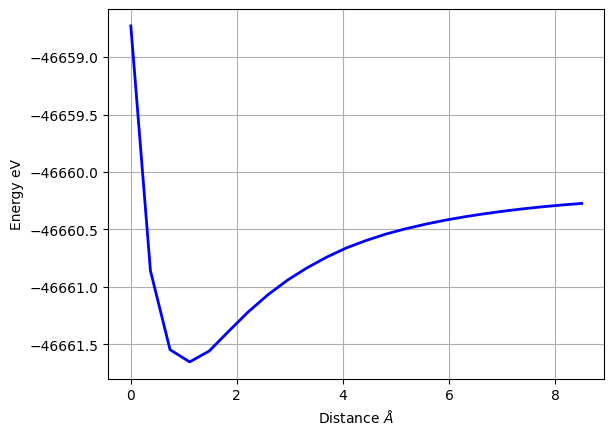

In [17]:
import matplotlib.pyplot as plt
plt.plot(dist_val[:], ener_val, color='blue', lw=2, label='Simulated VQE')
plt.ylabel('Energy eV')
plt.xlabel(r'Distance $\AA$')
plt.grid()
plt.show()

In [18]:
file = open('H2O/data.txt', 'w')
file.write(str(ener_val))
file.write('\n')
file.write(str(dist_val))
file.close()

Noisy Simulations

In [19]:
exp_qubit_op = []

for i in range(len(qubit_op)):
    aux = qubit_op[i].primitive.to_list()

    aux1 = aux[0][0][:]+'I'
    
    exp_qubit_op.append((aux1, aux[0][1]))
    
from qiskit.opflow.primitive_ops import PauliSumOp

auxP = PauliSumOp.from_list(exp_qubit_op)

In [20]:
from qiskit.providers.fake_provider import FakeJakartaV2

In [21]:
ansatz_opt = transpile(Ansatz, backend=FakeJakartaV2(), optimization_level =3)

print(ansatz_opt.decompose().count_ops())
ansatz_opt.draw()

OrderedDict([('sdg', 12), ('u1', 11), ('cx', 8), ('h', 6), ('u3', 1)])


global phase: 2π
                                                                               »
      q_5 -> 0 ────────────────────────────────────────────────────────────────»
                  ┌────┐  ┌─────────┐                                          »
      q_4 -> 1 ───┤ √X ├──┤ Rz(π/2) ├──────────────■───────────────────────────»
                  └────┘  └─────────┘              │                           »
      q_1 -> 2 ────────────────────────────────────┼───────────────────────────»
               ┌─────────┐   ┌────┐  ┌──────────┐┌─┴─┐                         »
      q_3 -> 3 ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(-π/2) ├┤ X ├──■───────────────────■──»
               └──┬───┬──┘   └────┘  └──────────┘└───┘  │                   │  »
      q_0 -> 4 ───┤ X ├─────────────────────────────────┼───────────────────┼──»
                  └───┘                               ┌─┴─┐┌─────────────┐┌─┴─┐»
      q_2 -> 5 ───────────────────────────────────────┤ X ├┤ Rz(2.0*t_0) ├┤ X ├»
                                                      └───┘└─────────────┘└───┘»
ancilla_0 -> 6 ────────────────────────────────────────────────────────────────»
                                                                               »
«                                                                       »
«      q_5 -> 0 ─────────────────■──────────────────────────────────────»
«                      ┌────┐  ┌─┴─┐                                    »
«      q_4 -> 1 ──■────┤ √X ├──┤ X ├─────────────■───────────────────■──»
«                 │    └────┘  └───┘             │                   │  »
«      q_1 -> 2 ──┼──────────────────────────────┼───────────────────┼──»
«               ┌─┴─┐┌────────┐┌────┐┌────────┐┌─┴─┐┌─────────────┐┌─┴─┐»
«      q_3 -> 3 ┤ X ├┤ Rz(-π) ├┤ √X ├┤ Rz(-π) ├┤ X ├┤ Rz(2.0*t_0) ├┤ X ├»
«               └───┘└────────┘└────┘└────────┘└───┘└─────────────┘└───┘»
«      q_0 -> 4 ────────────────────────────────────────────────────────»
«                                                                       »
«      q_2 -> 5 ────────────────────────────────────────────────────────»
«                                                                       »
«ancilla_0 -> 6 ────────────────────────────────────────────────────────»
«                                                                       »
«                                                          
«      q_5 -> 0 ─────■─────────────────────────────────────
«                  ┌─┴─┐   ┌─────────┐  ┌────┐  ┌─────────┐
«      q_4 -> 1 ───┤ X ├───┤ Rz(π/2) ├──┤ √X ├──┤ Rz(π/2) ├
«                  └───┘   └─────────┘  └────┘  └─────────┘
«      q_1 -> 2 ───────────────────────────────────────────
«               ┌─────────┐   ┌────┐  ┌────────┐           
«      q_3 -> 3 ┤ Rz(π/2) ├───┤ √X ├──┤ Rz(-π) ├───────────
«               └─────────┘   └────┘  └────────┘           
«      q_0 -> 4 ───────────────────────────────────────────
«                                                          
«      q_2 -> 5 ───────────────────────────────────────────
«                                                          
«ancilla_0 -> 6 ───────────────────────────────────────────
«

In [22]:
from qiskit.algorithms import MinimumEigensolver, VQEResult

# Define a custome VQE class to orchestra the ansatz, classical optimizers, 
# initial point, callback, and final result
class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        
    def compute_minimum_eigenvalue(self, operators, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x], shots=1024)
            
            # Get results from jobs
            est_result = job.result()
            
            # Get the measured energy value
            value = est_result.values[0]
            
            #Linear ZNE with global folding
            auxlist = [1]
            auxvalues = [value]
            
            def auxcircuit(n):
                
                t_0 = Parameter('t_0')
                weights = [1,1]
                paulis = ['IYXZII', 'ZXYIII']
                pauli_op = [([pauli,weight]) for pauli,weight in zip(paulis,weights)]

                h_aux = PauliSumOp.from_list([ op for op in pauli_op ])

                aux = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert((h_aux*t_0).exp_i())

                Ansatz = HartreeFock(num_spin_orbitals//2, num_particles, converter)
                
                Ansatz.append(aux, [i for i in range(num_spin_orbitals)])
                
                for i in range(n-1):
                    aux = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(-(h_aux*t_0).exp_i())
                    Ansatz.append(aux, [i for i in range(num_spin_orbitals)])
                    aux = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert((h_aux*t_0).exp_i())
                    Ansatz.append(aux, [i for i in range(num_spin_orbitals)])
                    
                    
                return transpile(Ansatz, backend=FakeJakartaV2(), optimization_level =3)

            auxlist.append(3)
            
            job = self._estimator.run([auxcircuit(3)], [operators], [x], shots=1024 )
            est_result = job.result()
            value = est_result.values[0]
            
            auxvalues.append(value)
            
            auxlist.append(5)
            
            job = self._estimator.run([auxcircuit(5)], [operators], [x], shots=1024 )
            est_result = job.result()
            value = est_result.values[0]
            
            auxvalues.append(value)
            
            model = np.poly1d(np.polyfit(auxlist,auxvalues, 1))
            value = model[0]
            
            # Save result information using callback function
            if self._callback is not None:
                self._callback(value)
            return value
            
        # Select an initial point for the ansatzs' parameters
        x0 = np.pi/4 * np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

In [23]:
# Define instance of qiskit-terra's Estimator primitive
estimator = Estimator([ansatz_opt], [auxP])
# Setup VQE algorithm

# Define a simple callback function
intermediate_info = []
def callback(value):
        intermediate_info.append(value)

custom_vqe = CustomVQE(estimator, ansatz_opt, optimizer, callback=callback)

# Run the custom VQE function and monitor execution time
start = time.time()
res_sim = custom_vqe.compute_minimum_eigenvalue(auxP)
end = time.time()

print(res_sim)
print(f'execution time (s): {end - start:.2f}')

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 18,
    'eigenstate': None,
    'eigenvalue': -5.9307899150146275,
    'optimal_circuit': None,
    'optimal_parameters': array([1.74658737]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}
execution time (s): 15.15


In [24]:
def Energ_calc(jj):
    
    if jj < 10:
        straux = 'H2O/step_00'+str(jj)+'.xyz'
    else:
        straux = 'H2O/step_0'+str(jj)+'.xyz'
    
    laux = []

    for i in range(4):
        aux = []
        for j in range(3):
            aux.append(float(coordinates[i*3+j])*0.52917721067121)
        laux.append(aux)

    # Define Molecule

    molecule = Molecule(
    # Coordinates in Angstrom
    geometry=[
        ["Cu", laux[0]],
        ["H", laux[1]],
        ["O", laux[2]],
        ["H", laux[3]]
    ],
    multiplicity=1,  # = 2*spin + 1
    charge=1,
)
    
    driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="cc-pVDZ",
    driver_type=ElectronicStructureDriverType.PYSCF)

    problem = ElectronicStructureProblem(
    driver,
    [ActiveSpaceTransformer(4,4)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    mapper = ParityMapper()
    converter = QubitConverter(mapper, two_qubit_reduction=True)
    hamiltonian = second_q_ops['ElectronicEnergy']
    qubit_op = converter.convert(hamiltonian)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = reducer.convert(qubit_op)
    num_particles = num_particles
    num_spin_orbitals = num_spin_orbitals -2
    
    ansatz_cp = ansatz_opt.copy()
     
    # Define instance of qiskit-terra's Estimator primitive
    estimator = Estimator([ansatz_cp], [auxP])
    # Setup VQE algorithm

    # Define a simple callback function
    intermediate_info = []
    def callback(value):
            intermediate_info.append(value)

    custom_vqe = CustomVQE(estimator, ansatz_cp, optimizer, callback=callback)

    # Run the custom VQE function and monitor execution time
    
    res_sim = custom_vqe.compute_minimum_eigenvalue(auxP)
    
    
    cmp_gs = problem.interpret(res_sim).total_energies[0].real
    
    return cmp_gs *  27.211

In [25]:
ener_val = []
dist_val = []
optimizer = COBYLA(100)
start = time.time()
for it in range(24):
    
    if it < 10:
        straux = 'H2O/step_00'+str(it)+'.xyz'
    else:
        straux = 'H2O/step_0'+str(it)+'.xyz'
    symbols, coordinates = qml.qchem.read_structure(straux)

    laux = []

    for i in range(4):
        aux = []
        for j in range(3):
            aux.append(float(coordinates[i*3+j]))
        laux.append(aux)


    dist_val.append(np.sqrt((laux[0][0]-laux[2][0])**2 + (laux[0][1]-laux[2][1])**2 + (laux[0][2]-laux[2][2])**2)-ref)
        
    ener_val.append(Energ_calc(it))
    print('STEP: ', it, ' Path Distance ', dist_val[-1], ' Energy ',ener_val[-1])
    
end = time.time()
print(f'execution time (s): {end - start:.2f}')

STEP:  0  Path Distance  0.0  Energy  -46632.622357868866
STEP:  1  Path Distance  0.36972905837879155  Energy  -46626.4382913506
STEP:  2  Path Distance  0.7394581167575929  Energy  -46625.75350855825
STEP:  3  Path Distance  1.1091871751364  Energy  -46637.97611395408
STEP:  4  Path Distance  1.4789162335152084  Energy  -46661.42862345351
STEP:  5  Path Distance  1.8486452918940262  Energy  -46668.66230212381
STEP:  6  Path Distance  2.218374350272843  Energy  -46665.024073096334
STEP:  7  Path Distance  2.5881034086516643  Energy  -46648.29134872459
STEP:  8  Path Distance  2.9578324670304768  Energy  -46639.82011439303
STEP:  9  Path Distance  3.327561525409308  Energy  -46638.746040657934
STEP:  10  Path Distance  3.69729058378813  Energy  -46639.18724569301
STEP:  11  Path Distance  4.067019642166954  Energy  -46639.24056696344
STEP:  12  Path Distance  4.4367487005457775  Energy  -46640.11734443483
STEP:  13  Path Distance  4.806477758924601  Energy  -46640.53210090673
STEP:  14

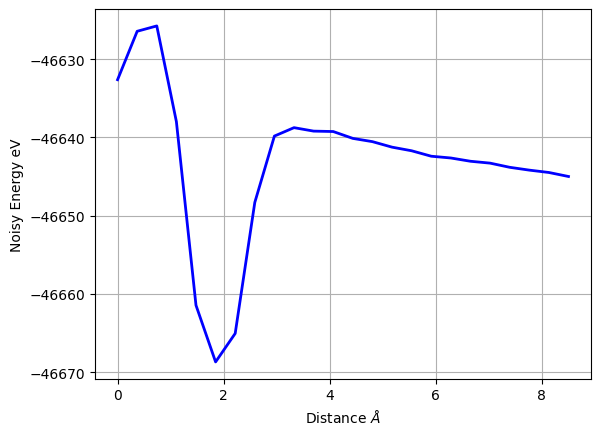

In [26]:
import matplotlib.pyplot as plt
plt.plot(dist_val[:], ener_val, color='blue', lw=2, label='Simulated VQE')
plt.ylabel('Noisy Energy eV')
plt.xlabel(r'Distance $\AA$')
plt.grid()
plt.show()

In [27]:
file = open('H2O/Noisy_data.txt', 'w')
file.write(str(ener_val))
file.write('\n')
file.write(str(dist_val))
file.close()